In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import math
import scipy
import torch
import matplotlib.pyplot as plt

import implicitmodules.torch as dm

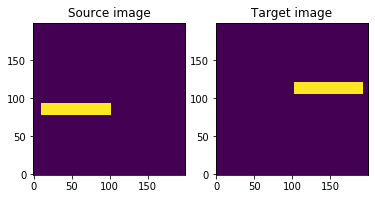

In [2]:
source_image = dm.Utilities.load_greyscale_image("../../data/images/bar_a.png", origin='lower')
target_image = dm.Utilities.load_greyscale_image("../../data/images/bar_b.png", origin='lower')

#%matplotlib qt5
plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(source_image, origin='lower')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(target_image, origin='lower')

plt.show()

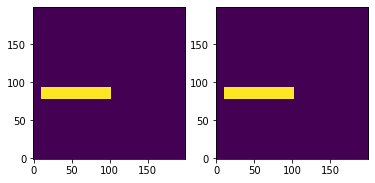

In [3]:
pos, im0 = dm.Utilities.sample_from_greyscale(source_image, 0., centered=False, normalise_weights=False, normalise_position=False)
im1 = dm.Utilities.deformed_intensities(pos-0.5, im0.view_as(source_image))

plt.subplot(1, 2, 1)
plt.imshow(im0.view_as(source_image), origin='lower')

plt.subplot(1, 2, 2)
plt.imshow(im1, origin='lower')

plt.show()

In [4]:
sig_smooth = 15
im0 = torch.tensor(scipy.ndimage.gaussian_filter(source_image, sig_smooth))
im1 = torch.tensor(scipy.ndimage.gaussian_filter(target_image, sig_smooth))

In [5]:
center = torch.tensor([[55., 85.]])

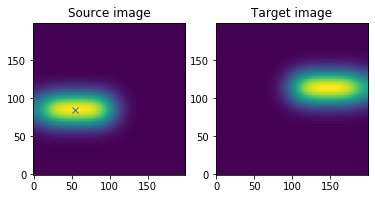

In [6]:
#%matplotlib qt5

plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(im0, origin='lower')
plt.plot(center[0, 0].numpy(), center[0, 1].numpy(), 'x')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(im1, origin='lower')

plt.show()

In [7]:
translation = dm.DeformationModules.ImplicitModule0(2, 1, 200., nu=0.1, gd=center.clone().requires_grad_())

In [8]:
model = dm.Models.ModelImageRegistration(im0, [translation], dm.Attachment.EuclideanPointwiseDistanceAttachment(), fit_gd=[False], lam=100.)

In [17]:
shoot_solver='rk4'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')

In [18]:
fitter.fit(im1.clone(), 100, costs=costs, options={'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS
Initial cost={'deformation': 4806.79296875, 'attach': 6156.73779296875, 'total': 10963.53125}
Time: 4.053732715001388
Iteration: 0
Costs
deformation=4806.79296875
attach=6156.73779296875
total=10963.53125
Time: 9.06130097100322
Iteration: 1
Costs
deformation=4806.79296875
attach=6156.73876953125
total=10963.53125
Optimisation process exited with message: Convergence achieved.
Final cost=10963.53125
Model evaluation count=11
Time elapsed = 9.061747689000185


In [11]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_image = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)

    

tensor([144.0818, 113.2361])
tensor([174.5000,  84.5000])
----------------------------
tensor([174.5000,  84.5000])
tensor([144.0818, 113.2361])
----------------------------
tensor([87.3938, 56.8901])
tensor([55.0000, 85.0000])
tensor([87.3938, 56.8901])


In [12]:
source_pos, source_weight = dm.Utilities.sample_from_greyscale(im0, 0., centered=False, normalise_weights=False, normalise_position=False)

In [14]:
compound = dm.DeformationModules.CompoundModule(model.modules)
compound.manifold.fill_gd([manifold.gd for manifold in model.init_manifold])
#silent = dm.DeformationModules.SilentLandmarks(2, source_pos.shape[0], gd=gd_pos)
compound.manifold.fill_cotan([manifold.cotan for manifold in model.init_manifold])
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(compound), shoot_solver, shoot_it)

deformed_translation_center = compound.manifold.gd[1][0].detach()

translation_center = model.init_manifold[1].gd.detach().flatten().tolist()
translation_moment = model.init_manifold[1].cotan.detach().flatten().tolist()

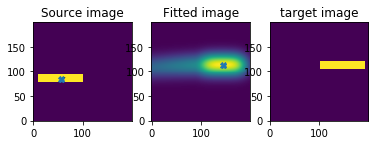

In [16]:
#%matplotlib qt5
plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image, origin='lower')
plt.plot(center.flatten().tolist()[0], center.flatten().tolist()[1], 'X')
plt.quiver(translation_center[0], translation_center[1],
           translation_moment[0], translation_moment[1])

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image, origin='lower')
#plt.imshow(im02.detach())#, origin='lower')
plt.plot(deformed_translation_center[0], deformed_translation_center[1], 'X')


plt.subplot(1, 3, 3)
plt.title("target image")
plt.imshow(target_image, origin='lower')

plt.show()